# TRAINING

In [1]:
import torch
import numpy as np
import pickle

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Product, ConstantKernel as C

import gym_sin
from gym import spaces

from utilities.arguments import get_args
from learner.posterior_multi_task import PosteriorMTAgent
from inference.inference_network import InferenceNetwork
from task.GuassianTaskGenerator import GaussianTaskGenerator
from utilities.folder_management import handle_folder_creation


In [2]:
def get_const_task_sequence(alpha, n_restarts, num_test_processes):
    kernel = C(1.0, (1e-5, 1e5)) * RBF(1, (1e-5, 1e5))

    gp_list = []
    for i in range(2):
        gp_list.append([GaussianProcessRegressor(kernel=kernel,
                                                 alpha=alpha ** 2,
                                                 normalize_y=True,
                                                 n_restarts_optimizer=n_restarts)
                        for _ in range(num_test_processes)])
    test_kwargs = []
    init_prior_test = [torch.tensor([[-10], [5]], dtype=torch.float32) for _ in range(num_test_processes)]
        
    mean = -5
    std = 5
    
    prior_seq = []
    for idx in range(50):
        prior_seq.append(torch.tensor([[mean], [std]], dtype=torch.float32))
        
    return gp_list, prior_seq, init_prior_test

def get_linear_task_sequence(alpha, n_restarts, num_test_processes):
    kernel = C(1.0, (1e-5, 1e5)) * RBF(1, (1e-5, 1e5))

    gp_list = []
    for i in range(2):
        gp_list.append([GaussianProcessRegressor(kernel=kernel,
                                                 alpha=alpha ** 2,
                                                 normalize_y=True,
                                                 n_restarts_optimizer=n_restarts)
                        for _ in range(num_test_processes)])
    test_kwargs = []
    init_prior_test = [torch.tensor([[30], [5]], dtype=torch.float32) for _ in range(num_test_processes)]

    for idx in range(50):
        std = 15
        mean = 30 - idx
        
        test_kwargs.append({'amplitude': 1,
                            'mean': mean,
                            'std': std,
                            'noise_std': 0.001,
                            'scale_reward': False})

    return gp_list, test_kwargs, init_prior_test

def get_phase_task_sequence(alpha, n_restarts, num_test_processes):
    kernel = C(1.0, (1e-5, 1e5)) * RBF(1, (1e-5, 1e5))

    gp_list = []
    for i in range(2):
        gp_list.append([GaussianProcessRegressor(kernel=kernel,
                                                 alpha=alpha ** 2,
                                                 normalize_y=True,
                                                 n_restarts_optimizer=n_restarts)
                        for _ in range(num_test_processes)])
    test_kwargs = []
    init_prior_test = [torch.tensor([[-5], [5]], dtype=torch.float32) for _ in range(num_test_processes)]

    for idx in range(50):
        if idx < 15:
            std = 15
            mean = 0
        elif idx < 30:
            std = 15
            mean = 10
        else:
            std = 15
            mean = 0
            
        test_kwargs.append({'amplitude': 1,
                            'mean': mean,
                            'std': std,
                            'noise_std': 0.001,
                            'scale_reward': False})

    return gp_list, test_kwargs, init_prior_test

def get_abrupt_and_smooth(alpha, n_restarts, num_test_processes):
    kernel = C(1.0, (1e-5, 1e5)) * RBF(1, (1e-5, 1e5))

    gp_list = []
    for i in range(2):
        gp_list.append([GaussianProcessRegressor(kernel=kernel,
                                                 alpha=alpha ** 2,
                                                 normalize_y=True,
                                                 n_restarts_optimizer=n_restarts)
                        for _ in range(num_test_processes)])
    test_kwargs = []
    init_prior_test = [torch.tensor([[-30], [5]], dtype=torch.float32) for _ in range(num_test_processes)]

    for idx in range(80):
        if idx < 15:
            std = 15
            mean = -30
        elif idx < 50:
            std = 15
            mean = -20 + (idx - 15)
        else:
            std = 15
            mean = -20 + 50 - 15 

            
        test_kwargs.append({'amplitude': 1,
                            'mean': mean,
                            'std': std,
                            'noise_std': 0.001,
                            'scale_reward': False})

    return gp_list, test_kwargs, init_prior_test


In [3]:
env_name = "gauss-v0"

action_space = spaces.Box(low=np.array([-1]), high=np.array([1]))
latent_dim = 1

x_min = -100
x_max = 100

min_mean = -40
max_mean = 40

prior_mu_min = -10
prior_mu_max = 10
prior_std_min = 1
prior_std_max = 10

std = 5
amplitude=1

device = "cpu"

In [13]:
task_generator = GaussianTaskGenerator(x_min, x_max, min_mean, max_mean,
                 prior_mu_min, prior_mu_max, prior_std_min, prior_std_max, std, amplitude)
fam = task_generator.create_task_family(n_tasks=5000, n_batches=1, test_perc=0, batch_size=150)

In [14]:
max_old = [100, 10]
min_old = [-100, 0]

vae_min_seq = 1
vae_max_seq = 150

obs_shape = (2,)

In [15]:
vi = InferenceNetwork(n_in=4, z_dim=latent_dim)
vi_optim = torch.optim.Adam(vi.parameters(), lr=1e-3)

In [16]:
agent = PosteriorMTAgent(action_space=action_space, device=device, gamma=0.999,
                                 num_steps=150, num_processes=32,
                                 clip_param=0.2, ppo_epoch=4,
                                 num_mini_batch=8,
                                 value_loss_coef=0.5,
                                 entropy_coef=0.,
                                 lr=0.0001,
                                 eps=1e-6, max_grad_norm=0.5,
                                 use_linear_lr_decay=False,
                                 use_gae=False,
                                 gae_lambda=0.95,
                                 use_proper_time_limits=False,
                                 obs_shape=obs_shape,
                                 latent_dim=latent_dim,
                                 recurrent_policy=False,
                                 hidden_size=16,
                                 use_elu=True,
                                 variational_model=vi,
                                 vae_optim=vi_optim,
                                 rescale_obs=True,
                                 max_old=max_old,
                                 min_old=min_old,
                                 vae_min_seq=vae_min_seq,
                                 vae_max_seq=vae_max_seq,
                                 max_action=100,
                                 min_action=-100,
                        use_time=False, rescale_time=None, max_time=None,
                        max_sigma=10)

In [17]:
gp_list, prior_seq, init_prior_test = get_const_task_sequence(alpha=0.25,
                                                          n_restarts=1,
                                                          num_test_processes=2)

In [18]:
res_eval, res_vae, test_list = agent.train(training_iter=5000,
                                                   env_name='gauss-v0',
                                                   seed=0,
                                                   task_generator=task_generator,
                                                   eval_interval=100,
                                                   log_dir=".",
                                                   use_env_obs=False,
                                                   num_vae_steps=1,
                                                   init_vae_steps=1,
                                                   sw_size=10,
                                                   num_random_task_to_eval=32,
                                                   num_test_processes=2,
                                                   use_true_sigma=True,
                                                   use_data_loader=True,
                                                   gp_list_sequences=[gp_list],
                                                   prior_sequences=[prior_seq],
                                                   init_prior_test_sequences=[init_prior_test],
                                                   verbose=True,
                                                   )

Epoch 0 MSE 455.74737548828125 KLD 67.88084411621094
Epoch 0 MSE 502.7608642578125 KLD 65.01753234863281
Epoch 0 MSE 572.1298828125 KLD 68.24220275878906
Epoch 0 MSE 457.326171875 KLD 54.84911346435547
Epoch 0 MSE 689.8262939453125 KLD 74.21588134765625
Epoch 0 MSE 654.3599853515625 KLD 81.73602294921875
Epoch 0 MSE 484.42437744140625 KLD 65.80840301513672
Epoch 0 MSE 668.4954223632812 KLD 90.09786224365234
Epoch 0 MSE 589.103515625 KLD 78.19864654541016
Epoch 0 MSE 410.5074157714844 KLD 65.86458587646484
Epoch 0 MSE 607.723388671875 KLD 56.845069885253906
Epoch 0 MSE 420.8643493652344 KLD 43.66068649291992
Epoch 0 MSE 537.2147216796875 KLD 76.60128784179688
Epoch 0 MSE 555.9805297851562 KLD 53.4024658203125
Epoch 0 MSE 588.0371704101562 KLD 90.11909484863281
Epoch 0 MSE 496.3413391113281 KLD 50.559104919433594
Epoch 0 MSE 468.1184997558594 KLD 56.51182556152344
Epoch 0 MSE 591.3516845703125 KLD 71.122314453125
Epoch 0 MSE 425.787353515625 KLD 39.9231071472168
Epoch 0 MSE 596.473815917

Epoch 0 MSE 87.91304016113281 KLD 13.048964500427246
Epoch 0 MSE 70.89208984375 KLD 7.022993087768555
Epoch 0 MSE 53.6639518737793 KLD 5.533952713012695
Epoch 0 MSE 55.675682067871094 KLD 4.980097770690918
Epoch 0 MSE 84.15113067626953 KLD 8.90318775177002
Epoch 0 MSE 189.14373779296875 KLD 26.108306884765625
Epoch 0 MSE 56.36514663696289 KLD 3.2885897159576416
Epoch 0 MSE 48.07288360595703 KLD 5.605459213256836
Epoch 0 MSE 50.3721809387207 KLD 5.311288833618164
Epoch 0 MSE 60.73688888549805 KLD 6.724209785461426
Epoch 0 MSE 191.73947143554688 KLD 29.970035552978516
Epoch 0 MSE 66.96293640136719 KLD 8.489672660827637
Epoch 0 MSE 61.69120407104492 KLD 6.986583232879639
Epoch 0 MSE 160.44247436523438 KLD 24.61502456665039
Epoch 0 MSE 50.048683166503906 KLD 3.3083627223968506
Epoch 0 MSE 54.314781188964844 KLD 6.108729839324951
Epoch 0 MSE 35.76274871826172 KLD 2.7783336639404297
Epoch 0 MSE 47.46054458618164 KLD 3.5589914321899414
Epoch 0 MSE 48.3662223815918 KLD 6.200448989868164
Epoch 

Epoch 0 MSE 30.520029067993164 KLD 2.7143919467926025
Epoch 0 MSE 34.31644821166992 KLD 1.2847771644592285
Epoch 0 MSE 44.61909866333008 KLD 1.2348220348358154
Epoch 0 MSE 113.44100189208984 KLD 17.97228240966797
Epoch 0 MSE 38.10561752319336 KLD 1.1503827571868896
Epoch 0 MSE 44.71434783935547 KLD 4.129929542541504
Epoch 0 MSE 36.955867767333984 KLD 1.115617275238037
Epoch 0 MSE 37.57707595825195 KLD 1.2820029258728027
Epoch 0 MSE 19.03240394592285 KLD 1.6726341247558594
Epoch 0 MSE 81.63953399658203 KLD 8.460869789123535
Epoch 0 MSE 56.49372100830078 KLD 2.3243601322174072
Epoch 0 MSE 28.428054809570312 KLD 1.3253179788589478
Epoch 0 MSE 30.288536071777344 KLD 1.901507019996643
Epoch 0 MSE 73.45124053955078 KLD 7.447004795074463
Epoch 0 MSE 16.81049919128418 KLD 1.2412054538726807
Epoch 0 MSE 28.290538787841797 KLD 1.057379126548767
Epoch 0 MSE 23.67927360534668 KLD 1.0751385688781738
Epoch 0 MSE 29.362937927246094 KLD 1.190974235534668
Epoch 0 MSE 24.717529296875 KLD 1.0386722087860

Epoch 0 MSE 21.12790298461914 KLD 1.082521915435791
Epoch 0 MSE 28.88520050048828 KLD 1.9521082639694214
Epoch 0 MSE 41.28439712524414 KLD 1.0237646102905273
Epoch 0 MSE 22.203519821166992 KLD 2.3504981994628906
Epoch 0 MSE 32.22833251953125 KLD 4.103780746459961
Epoch 0 MSE 31.958303451538086 KLD 2.684861660003662
Epoch 0 MSE 15.596282958984375 KLD 1.1653523445129395
Epoch 0 MSE 29.459579467773438 KLD 0.9918951988220215
Epoch 0 MSE 31.747493743896484 KLD 1.151197910308838
Epoch 0 MSE 27.152633666992188 KLD 2.4376678466796875
Epoch 0 MSE 64.54341125488281 KLD 5.7819952964782715
Epoch 0 MSE 43.71337890625 KLD 1.6820858716964722
Epoch 0 MSE 49.538108825683594 KLD 1.1944681406021118
Epoch 0 MSE 22.388948440551758 KLD 1.230346918106079
Epoch 0 MSE 29.52623748779297 KLD 2.8556947708129883
Epoch 0 MSE 40.43170928955078 KLD 1.2323143482208252
Epoch 0 MSE 19.747724533081055 KLD 0.9831914901733398
Epoch 0 MSE 36.94151306152344 KLD 1.9232789278030396
Epoch 0 MSE 30.070938110351562 KLD 2.25820708

Epoch 0 MSE 41.95817947387695 KLD 1.0957655906677246
Epoch 0 MSE 25.153396606445312 KLD 1.0894526243209839
Epoch 0 MSE 29.240449905395508 KLD 1.0564521551132202
Epoch 0 MSE 26.873754501342773 KLD 1.1069691181182861
Epoch 0 MSE 65.30098724365234 KLD 1.297940969467163
Epoch 0 MSE 53.36442184448242 KLD 4.885051250457764
Epoch 0 MSE 34.16508865356445 KLD 1.0811803340911865
Epoch 0 MSE 32.250118255615234 KLD 1.3512505292892456
Epoch 0 MSE 19.66187858581543 KLD 1.559460163116455
Epoch 0 MSE 41.806766510009766 KLD 1.1986334323883057
Epoch 0 MSE 18.064281463623047 KLD 1.7932462692260742
Epoch 0 MSE 24.171953201293945 KLD 1.023749828338623
Epoch 0 MSE 29.918167114257812 KLD 1.0483274459838867
Epoch 0 MSE 29.456647872924805 KLD 2.5571255683898926
Epoch 0 MSE 44.23997116088867 KLD 1.2796427011489868
Epoch 0 MSE 22.639354705810547 KLD 1.1564186811447144
Epoch 0 MSE 28.133012771606445 KLD 1.648502230644226
Epoch 0 MSE 28.798933029174805 KLD 1.2432979345321655
Epoch 0 MSE 32.323516845703125 KLD 1.22

Epoch 0 MSE 23.32595443725586 KLD 1.1226009130477905
Epoch 0 MSE 41.42337417602539 KLD 1.5638747215270996
Epoch 0 MSE 67.7504653930664 KLD 8.91952133178711
Epoch 0 MSE 40.87558364868164 KLD 1.879441738128662
Epoch 0 MSE 21.053861618041992 KLD 0.9630756378173828
Epoch 0 MSE 31.379552841186523 KLD 1.3107030391693115
Epoch 0 MSE 28.905338287353516 KLD 1.3005956411361694
Epoch 0 MSE 17.934898376464844 KLD 1.2897052764892578
Epoch 0 MSE 50.651920318603516 KLD 1.723822832107544
Epoch 0 MSE 18.165498733520508 KLD 1.4428044557571411
Epoch 0 MSE 17.009544372558594 KLD 1.1964588165283203
Epoch 0 MSE 35.91290283203125 KLD 1.3872334957122803
Epoch 0 MSE 41.532684326171875 KLD 3.403818368911743
Epoch 0 MSE 34.641719818115234 KLD 1.35817289352417
Epoch 0 MSE 15.193912506103516 KLD 2.042346239089966
Epoch 0 MSE 29.86383056640625 KLD 1.1536096334457397
Epoch 0 MSE 39.15665054321289 KLD 1.3244986534118652
Epoch 0 MSE 30.421058654785156 KLD 1.2782480716705322
Epoch 0 MSE 26.077680587768555 KLD 1.6111834

Epoch 0 MSE 23.425640106201172 KLD 1.5822125673294067
Epoch 0 MSE 17.967453002929688 KLD 1.5198217630386353
Epoch 0 MSE 16.507768630981445 KLD 1.3316041231155396
Epoch 0 MSE 36.30686569213867 KLD 3.3986494541168213
Epoch 0 MSE 25.371156692504883 KLD 1.478424310684204
Epoch 0 MSE 75.12886047363281 KLD 9.265048027038574
Epoch 0 MSE 43.18898391723633 KLD 1.4564836025238037
Epoch 0 MSE 38.75417709350586 KLD 1.5176708698272705
Epoch 0 MSE 39.6732063293457 KLD 1.858840823173523
Epoch 0 MSE 15.5028657913208 KLD 1.349130392074585
Epoch 0 MSE 19.508974075317383 KLD 1.7997422218322754
Epoch 0 MSE 30.255054473876953 KLD 1.3953073024749756
Epoch 0 MSE 32.39299011230469 KLD 2.37394118309021
Epoch 0 MSE 42.144962310791016 KLD 1.4664450883865356
Epoch 0 MSE 21.519710540771484 KLD 1.6257764101028442
Epoch 0 MSE 13.539328575134277 KLD 1.5653800964355469
Epoch 0 MSE 43.23695373535156 KLD 1.4712004661560059
Epoch 0 MSE 24.561729431152344 KLD 1.7004989385604858
Epoch 0 MSE 21.91073989868164 KLD 1.45010149

Epoch 0 MSE 22.585865020751953 KLD 1.5466704368591309
Epoch 0 MSE 17.732200622558594 KLD 1.5808420181274414
Epoch 0 MSE 18.586286544799805 KLD 2.028501510620117
Epoch 0 MSE 11.7815523147583 KLD 1.6697657108306885
Epoch 0 MSE 14.924034118652344 KLD 1.9575220346450806
Epoch 0 MSE 20.374759674072266 KLD 2.3760504722595215
Epoch 0 MSE 25.59506607055664 KLD 1.9287368059158325
Epoch 0 MSE 23.165790557861328 KLD 1.7203772068023682
Epoch 0 MSE 10.886361122131348 KLD 1.8563296794891357
Epoch 0 MSE 20.77618980407715 KLD 1.8164265155792236
Epoch 0 MSE 36.00232696533203 KLD 2.3988590240478516
Epoch 0 MSE 20.067354202270508 KLD 1.959043264389038
Epoch 0 MSE 31.526336669921875 KLD 1.693896770477295
Epoch 0 MSE 14.961180686950684 KLD 1.9534165859222412
Epoch 0 MSE 35.50209045410156 KLD 2.405607223510742
Epoch 0 MSE 26.18021011352539 KLD 1.7155749797821045
Epoch 0 MSE 26.17424774169922 KLD 2.3286564350128174
Epoch 0 MSE 23.155466079711914 KLD 2.012669563293457
Epoch 0 MSE 33.44195556640625 KLD 3.20116

Epoch 0 MSE 10.912704467773438 KLD 2.2779242992401123
Epoch 0 MSE 21.196704864501953 KLD 2.225189685821533
Epoch 0 MSE 19.864320755004883 KLD 1.9270849227905273
Epoch 0 MSE 28.623550415039062 KLD 2.3868701457977295
Epoch 0 MSE 28.087594985961914 KLD 2.1681742668151855
Epoch 0 MSE 12.214581489562988 KLD 1.9282896518707275
Epoch 0 MSE 12.098421096801758 KLD 2.7261862754821777
Epoch 0 MSE 39.29583740234375 KLD 2.3082661628723145
Epoch 0 MSE 16.549684524536133 KLD 1.680598497390747
Epoch 0 MSE 34.078697204589844 KLD 2.188713788986206
Epoch 0 MSE 20.252941131591797 KLD 2.027998924255371
Epoch 0 MSE 14.18108081817627 KLD 1.7258127927780151
Epoch 0 MSE 37.46206283569336 KLD 7.900307655334473
Epoch 0 MSE 13.988469123840332 KLD 2.501530885696411
Epoch 0 MSE 30.842126846313477 KLD 1.7901099920272827
Epoch 0 MSE 29.701847076416016 KLD 1.7112510204315186
Epoch 0 MSE 30.548532485961914 KLD 2.093194007873535
Epoch 0 MSE 26.840553283691406 KLD 2.0402700901031494
Epoch 0 MSE 7.746298789978027 KLD 2.27

Epoch 0 MSE 25.046159744262695 KLD 2.919328451156616
Epoch 0 MSE 16.31874656677246 KLD 2.0760390758514404
Epoch 0 MSE 17.665353775024414 KLD 1.8337223529815674
Epoch 0 MSE 15.152987480163574 KLD 2.073659896850586
Epoch 0 MSE 26.96188735961914 KLD 1.954048991203308
Epoch 0 MSE 10.731101989746094 KLD 1.8988747596740723
Epoch 0 MSE 12.127372741699219 KLD 1.9870638847351074
Epoch 0 MSE 11.062637329101562 KLD 2.109731674194336
Epoch 0 MSE 16.814786911010742 KLD 1.830519437789917
Epoch 0 MSE 12.564699172973633 KLD 1.9898426532745361
Epoch 0 MSE 20.58228874206543 KLD 2.6357479095458984
Epoch 0 MSE 19.917789459228516 KLD 1.8274316787719727
Epoch 0 MSE 17.328418731689453 KLD 1.839735984802246
Epoch 0 MSE 27.810108184814453 KLD 3.0137925148010254
Epoch 0 MSE 18.094646453857422 KLD 2.508493661880493
Epoch 0 MSE 11.594826698303223 KLD 2.725557327270508
Epoch 0 MSE 18.653844833374023 KLD 2.46948504447937
Epoch 0 MSE 21.67084503173828 KLD 1.9133496284484863
Epoch 0 MSE 8.022976875305176 KLD 1.870223

Epoch 0 MSE 17.082002639770508 KLD 1.8352367877960205
Epoch 0 MSE 6.947445869445801 KLD 1.3246909379959106
Epoch 0 MSE 13.094491958618164 KLD 2.2167577743530273
Epoch 0 MSE 7.295652866363525 KLD 2.165283203125
Epoch 0 MSE 11.578133583068848 KLD 2.023378849029541
Epoch 0 MSE 17.236623764038086 KLD 2.4992752075195312
Epoch 0 MSE 4.828219413757324 KLD 2.169862985610962
Epoch 0 MSE 11.15304946899414 KLD 2.4608371257781982
Epoch 0 MSE 16.0644474029541 KLD 2.349419116973877
Epoch 0 MSE 25.87451934814453 KLD 1.8799532651901245
Epoch 0 MSE 11.1959810256958 KLD 2.2366466522216797
Epoch 0 MSE 10.059514045715332 KLD 2.006575107574463
Epoch 0 MSE 16.275266647338867 KLD 3.388291835784912
Epoch 0 MSE 8.864713668823242 KLD 1.9640711545944214
Epoch 0 MSE 7.435007572174072 KLD 2.637601613998413
Epoch 0 MSE 15.363240242004395 KLD 2.1775870323181152
Epoch 0 MSE 19.491500854492188 KLD 2.131836175918579
Epoch 0 MSE 16.905057907104492 KLD 3.2193877696990967
Epoch 0 MSE 6.098894119262695 KLD 3.26722621917724

Epoch 0 MSE 13.03908634185791 KLD 1.8440349102020264
Epoch 0 MSE 20.78601837158203 KLD 2.4438724517822266
Epoch 0 MSE 10.952085494995117 KLD 4.361944198608398
Epoch 0 MSE 3.0697410106658936 KLD 1.7545801401138306
Epoch 0 MSE 21.894250869750977 KLD 2.2035598754882812
Epoch 0 MSE 10.620829582214355 KLD 2.8178465366363525
Epoch 0 MSE 8.06973934173584 KLD 1.6555557250976562
Epoch 0 MSE 29.1982421875 KLD 1.9782185554504395
Epoch 0 MSE 10.144798278808594 KLD 2.221816301345825
Epoch 0 MSE 9.14826774597168 KLD 2.2300913333892822
Epoch 0 MSE 18.46339988708496 KLD 2.1601943969726562
Epoch 0 MSE 10.608776092529297 KLD 1.9623289108276367
Epoch 0 MSE 10.76927661895752 KLD 2.730301856994629
Epoch 0 MSE 6.265743732452393 KLD 2.107881546020508
Epoch 0 MSE 10.545856475830078 KLD 1.8135420083999634
Epoch 0 MSE 3.946568489074707 KLD 2.6451456546783447
Epoch 0 MSE 18.214752197265625 KLD 2.4268457889556885
Epoch 0 MSE 6.1405134201049805 KLD 2.4061877727508545
Epoch 0 MSE 15.048937797546387 KLD 2.8410360813

Epoch 0 MSE 15.254392623901367 KLD 2.250643730163574
Epoch 0 MSE 13.324663162231445 KLD 3.474146842956543
Epoch 0 MSE 10.43234634399414 KLD 2.3978989124298096
Epoch 0 MSE 10.021186828613281 KLD 2.4403090476989746
Epoch 0 MSE 14.122493743896484 KLD 3.065084934234619
Epoch 0 MSE 27.89386749267578 KLD 2.550389528274536
Epoch 0 MSE 20.967878341674805 KLD 1.9662280082702637
Epoch 0 MSE 14.653850555419922 KLD 3.512862205505371
Epoch 0 MSE 15.407785415649414 KLD 1.990164875984192
Epoch 0 MSE 5.456146240234375 KLD 2.071960687637329
Epoch 0 MSE 11.578153610229492 KLD 2.0671143531799316
Epoch 0 MSE 30.54061508178711 KLD 2.4931960105895996
Epoch 0 MSE 10.983865737915039 KLD 2.2935469150543213
Epoch 0 MSE 10.262526512145996 KLD 2.235123872756958
Epoch 0 MSE 21.994367599487305 KLD 2.3125085830688477
Epoch 0 MSE 17.91722297668457 KLD 2.2257235050201416
Epoch 0 MSE 10.740411758422852 KLD 2.770552158355713
Epoch 0 MSE 13.52709674835205 KLD 3.533424139022827
Epoch 0 MSE 11.927077293395996 KLD 1.8290371

Epoch 0 MSE 36.72365951538086 KLD 3.6157898902893066
Epoch 0 MSE 7.323486328125 KLD 2.4070518016815186
Epoch 0 MSE 9.150172233581543 KLD 1.7701481580734253
Epoch 0 MSE 6.240412712097168 KLD 2.0166826248168945
Epoch 0 MSE 6.833470344543457 KLD 2.686728000640869
Epoch 0 MSE 9.553857803344727 KLD 2.863595724105835
Epoch 0 MSE 7.969409942626953 KLD 3.026614189147949
Epoch 0 MSE 9.221728324890137 KLD 3.284937858581543
Epoch 0 MSE 38.63163375854492 KLD 3.089545726776123
Epoch 0 MSE 6.043150901794434 KLD 3.2948336601257324
Epoch 0 MSE 3.410982131958008 KLD 2.8202853202819824
Epoch 0 MSE 10.840276718139648 KLD 2.1487302780151367
Epoch 0 MSE 12.763916969299316 KLD 2.3383800983428955
Epoch 0 MSE 4.375006675720215 KLD 3.143617868423462
Epoch 0 MSE 16.414878845214844 KLD 3.008155107498169
Epoch 0 MSE 17.400962829589844 KLD 2.1858274936676025
Epoch 0 MSE 6.831254959106445 KLD 2.950092077255249
Epoch 0 MSE 15.179363250732422 KLD 2.0965912342071533
Epoch 0 MSE 16.142776489257812 KLD 2.128857612609863

Epoch 0 MSE 16.657583236694336 KLD 3.4113242626190186
Epoch 0 MSE 12.443656921386719 KLD 2.71079421043396
Epoch 0 MSE 4.47914981842041 KLD 1.6116596460342407
Epoch 0 MSE 5.241312503814697 KLD 1.6753125190734863
Epoch 0 MSE 14.228616714477539 KLD 2.8183658123016357
Epoch 0 MSE 16.516834259033203 KLD 2.736964225769043
Epoch 0 MSE 9.17547607421875 KLD 2.95401668548584
Epoch 0 MSE 10.144737243652344 KLD 2.0209779739379883
Epoch 0 MSE 5.874640464782715 KLD 2.515077829360962
Epoch 0 MSE 6.746122360229492 KLD 2.360130548477173
Epoch 0 MSE 8.375280380249023 KLD 2.190417766571045
Epoch 0 MSE 9.416577339172363 KLD 2.344251871109009
Epoch 0 MSE 12.945704460144043 KLD 2.421203374862671
Epoch 0 MSE 16.533218383789062 KLD 2.74342942237854
Epoch 0 MSE 44.7496452331543 KLD 2.5430383682250977
Epoch 0 MSE 8.116830825805664 KLD 2.7582650184631348
Epoch 0 MSE 6.09822940826416 KLD 2.594403028488159
Epoch 0 MSE 8.721329689025879 KLD 2.7310941219329834
Epoch 0 MSE 15.82686710357666 KLD 3.989114284515381
Epoc

Epoch 0 MSE 9.335334777832031 KLD 2.834350109100342
Epoch 0 MSE 6.742957592010498 KLD 2.896413803100586
Epoch 0 MSE 4.512480735778809 KLD 2.8039441108703613
Epoch 0 MSE 16.033355712890625 KLD 3.3162221908569336
Epoch 0 MSE 6.37368631362915 KLD 2.840608835220337
Epoch 0 MSE 7.214197635650635 KLD 2.9361722469329834
Epoch 0 MSE 5.893447399139404 KLD 3.1002445220947266
Epoch 0 MSE 5.1612043380737305 KLD 1.8412741422653198
Epoch 0 MSE 11.290302276611328 KLD 2.302180528640747
Epoch 0 MSE 9.682536125183105 KLD 2.7538137435913086
Epoch 0 MSE 8.209468841552734 KLD 1.9256194829940796
Epoch 0 MSE 10.477889060974121 KLD 1.962680459022522
Epoch 0 MSE 8.117524147033691 KLD 1.8769553899765015
Epoch 0 MSE 5.987468242645264 KLD 1.7043527364730835
Epoch 0 MSE 26.868003845214844 KLD 3.2551755905151367
Epoch 0 MSE 3.7532103061676025 KLD 1.988084077835083
Epoch 0 MSE 3.171086072921753 KLD 2.350351095199585
Epoch 0 MSE 13.629632949829102 KLD 1.851501226425171
Epoch 0 MSE 4.193727970123291 KLD 2.547823905944

Epoch 0 MSE 14.522923469543457 KLD 2.189516305923462
Epoch 0 MSE 6.157933235168457 KLD 2.211216449737549
Epoch 0 MSE 6.647157669067383 KLD 2.6978321075439453
Epoch 0 MSE 4.7015862464904785 KLD 2.3175230026245117
Epoch 0 MSE 10.666765213012695 KLD 3.0286355018615723
Epoch 0 MSE 9.192400932312012 KLD 2.4420981407165527
Epoch 0 MSE 8.337589263916016 KLD 3.293851852416992
Epoch 0 MSE 9.403023719787598 KLD 2.3641281127929688
Epoch 0 MSE 4.227826118469238 KLD 2.2394678592681885
Epoch 0 MSE 8.057821273803711 KLD 2.2715933322906494
Epoch 0 MSE 7.1724138259887695 KLD 2.1523733139038086
Epoch 0 MSE 3.683549404144287 KLD 3.155243396759033
Epoch 0 MSE 9.033556938171387 KLD 2.696613073348999
Epoch 0 MSE 4.0157294273376465 KLD 3.5515146255493164
Epoch 0 MSE 3.9507670402526855 KLD 2.6120991706848145
Epoch 0 MSE 3.903350353240967 KLD 2.204993963241577
Epoch 0 MSE 4.781913757324219 KLD 2.526491641998291
Epoch 0 MSE 6.561618804931641 KLD 2.134652853012085
Epoch 0 MSE 4.730950832366943 KLD 2.005046844482

Epoch 0 MSE 3.6433658599853516 KLD 2.0437207221984863
Epoch 0 MSE 10.254372596740723 KLD 2.9436919689178467
Epoch 0 MSE 32.635128021240234 KLD 2.420475959777832
Epoch 0 MSE 35.0958366394043 KLD 2.732557535171509
Epoch 0 MSE 20.30064582824707 KLD 1.8572924137115479
Epoch 0 MSE 15.271561622619629 KLD 2.045076370239258
Epoch 0 MSE 5.489413738250732 KLD 3.0793614387512207
Epoch 0 MSE 3.861288547515869 KLD 2.8924615383148193
Epoch 0 MSE 22.211528778076172 KLD 2.865203380584717
Epoch 0 MSE 6.598466396331787 KLD 3.105766773223877
Epoch 0 MSE 18.37890625 KLD 2.993788719177246
Epoch 0 MSE 2.15460205078125 KLD 2.2675294876098633
Epoch 0 MSE 4.567856788635254 KLD 1.894514560699463
Epoch 0 MSE 14.20037841796875 KLD 3.0169219970703125
Epoch 0 MSE 12.99376106262207 KLD 2.047297239303589
Epoch 0 MSE 3.2997708320617676 KLD 2.8722848892211914
Epoch 0 MSE 6.73084020614624 KLD 3.057833671569824
Epoch 0 MSE 9.878872871398926 KLD 2.0288679599761963
Epoch 0 MSE 11.412577629089355 KLD 1.7806826829910278
Epoc

Epoch 0 MSE 5.316750526428223 KLD 2.509526491165161
Epoch 0 MSE 4.15927791595459 KLD 1.8951669931411743
Epoch 0 MSE 5.408233642578125 KLD 2.2477033138275146
Epoch 0 MSE 4.669558525085449 KLD 2.803370714187622
Epoch 0 MSE 11.36098861694336 KLD 3.2054169178009033
Epoch 0 MSE 5.310565948486328 KLD 2.4168167114257812
Epoch 0 MSE 15.879227638244629 KLD 1.9175200462341309
Epoch 0 MSE 16.861379623413086 KLD 2.3874762058258057
Epoch 0 MSE 7.966374397277832 KLD 2.577871799468994
Epoch 0 MSE 4.96892786026001 KLD 4.631211757659912
Epoch 0 MSE 4.924622535705566 KLD 3.847649335861206
Epoch 0 MSE 5.782905578613281 KLD 2.8390469551086426
Epoch 0 MSE 18.772520065307617 KLD 3.1498451232910156
Epoch 0 MSE 34.92815399169922 KLD 2.6072092056274414
Epoch 0 MSE 5.161263942718506 KLD 2.7553062438964844
Epoch 0 MSE 6.316451549530029 KLD 2.394608497619629
Epoch 0 MSE 11.471324920654297 KLD 2.6556906700134277
Epoch 0 MSE 5.875858783721924 KLD 1.587404489517212
Epoch 0 MSE 6.579741954803467 KLD 3.375246047973633

Epoch 0 MSE 5.261734962463379 KLD 3.016387939453125
Epoch 0 MSE 7.246222496032715 KLD 3.109924554824829
Epoch 0 MSE 2.821610927581787 KLD 3.0575368404388428
Epoch 0 MSE 4.033963203430176 KLD 1.8738110065460205
Epoch 0 MSE 9.779054641723633 KLD 2.83577561378479
Epoch 0 MSE 28.39056396484375 KLD 1.9046051502227783
Epoch 0 MSE 3.7941603660583496 KLD 2.7881641387939453
Epoch 0 MSE 2.6291048526763916 KLD 2.7640836238861084
Epoch 0 MSE 3.2701590061187744 KLD 2.825259208679199
Epoch 0 MSE 4.859152793884277 KLD 2.242964029312134
Epoch 0 MSE 2.9783542156219482 KLD 2.809842109680176
Epoch 0 MSE 2.5541739463806152 KLD 3.642326831817627
Epoch 0 MSE 9.002408981323242 KLD 3.1379318237304688
Epoch 0 MSE 5.383331298828125 KLD 1.9760408401489258
Epoch 0 MSE 12.546080589294434 KLD 2.313887596130371
Epoch 0 MSE 3.9896016120910645 KLD 4.130669116973877
Epoch 0 MSE 1.9685635566711426 KLD 2.9247729778289795
Epoch 0 MSE 6.902553558349609 KLD 3.457761287689209
Epoch 0 MSE 3.160372495651245 KLD 2.4994773864746

Epoch 0 MSE 2.8669228553771973 KLD 3.4978668689727783
Epoch 0 MSE 5.634164333343506 KLD 3.3781445026397705
Epoch 0 MSE 11.7922945022583 KLD 2.7165350914001465
Epoch 0 MSE 3.1005911827087402 KLD 2.4148051738739014
Epoch 0 MSE 3.5119800567626953 KLD 2.268692970275879
Epoch 0 MSE 10.474344253540039 KLD 2.743863582611084
Epoch 0 MSE 3.072986125946045 KLD 2.0808231830596924
Epoch 0 MSE 2.3719797134399414 KLD 2.919398069381714
Epoch 0 MSE 6.137253284454346 KLD 2.5950684547424316
Epoch 0 MSE 1.967067837715149 KLD 1.9612115621566772
Epoch 0 MSE 4.049281597137451 KLD 2.6578996181488037
Epoch 0 MSE 2.8516759872436523 KLD 2.2912845611572266
Epoch 0 MSE 2.4812607765197754 KLD 2.227067232131958
Epoch 0 MSE 2.7163095474243164 KLD 3.8984673023223877
Epoch 0 MSE 15.357510566711426 KLD 2.9853456020355225
Epoch 0 MSE 3.0692708492279053 KLD 3.3060009479522705
Epoch 0 MSE 6.454492568969727 KLD 2.8619110584259033
Epoch 0 MSE 1.755384087562561 KLD 2.088446617126465
Epoch 0 MSE 2.8591771125793457 KLD 4.48769

Epoch 0 MSE 35.74250793457031 KLD 4.680971145629883
Epoch 0 MSE 4.41787576675415 KLD 3.1151318550109863
Epoch 0 MSE 4.030692100524902 KLD 1.5263667106628418
Epoch 0 MSE 3.840756416320801 KLD 2.611298084259033
Epoch 0 MSE 6.6822919845581055 KLD 2.9519965648651123
Epoch 0 MSE 2.4251108169555664 KLD 1.7137949466705322
Epoch 0 MSE 2.28153657913208 KLD 2.664250373840332
Epoch 0 MSE 3.2601799964904785 KLD 2.8307793140411377
Epoch 0 MSE 6.4728617668151855 KLD 3.4558513164520264
Epoch 0 MSE 3.3467416763305664 KLD 1.731233835220337
Epoch 0 MSE 3.8570897579193115 KLD 2.50388765335083
Epoch 0 MSE 5.248613357543945 KLD 2.97747540473938
Epoch 0 MSE 3.179600715637207 KLD 3.182155132293701
Epoch 0 MSE 7.430976390838623 KLD 3.953162670135498
Epoch 0 MSE 5.477738380432129 KLD 3.413663387298584
Epoch 0 MSE 26.694713592529297 KLD 2.810493230819702
Epoch 0 MSE 5.186424255371094 KLD 2.898142099380493
Epoch 0 MSE 2.4324917793273926 KLD 4.076884746551514
Epoch 0 MSE 8.311315536499023 KLD 2.2980101108551025
E

Epoch 0 MSE 15.666787147521973 KLD 2.492748975753784
Epoch 0 MSE 5.770644187927246 KLD 2.970900774002075
Epoch 0 MSE 6.451426029205322 KLD 2.274120569229126
Epoch 0 MSE 13.01518440246582 KLD 2.0177876949310303
Epoch 0 MSE 13.500861167907715 KLD 4.039276123046875
Epoch 0 MSE 24.41956329345703 KLD 3.7036263942718506
Epoch 0 MSE 2.902987003326416 KLD 2.1438522338867188
Epoch 0 MSE 5.726555347442627 KLD 2.9228479862213135
Epoch 0 MSE 30.30179214477539 KLD 2.617722272872925
Epoch 0 MSE 5.5488152503967285 KLD 2.769198179244995
Epoch 0 MSE 4.739114284515381 KLD 2.999192953109741
Epoch 0 MSE 17.009937286376953 KLD 2.107600688934326
Epoch 0 MSE 4.985136985778809 KLD 2.584209680557251
Epoch 0 MSE 2.3420374393463135 KLD 2.5103399753570557
Epoch 0 MSE 13.781197547912598 KLD 3.272798538208008
Epoch 0 MSE 3.3215415477752686 KLD 3.9123988151550293
Epoch 0 MSE 5.347538471221924 KLD 2.5795974731445312
Epoch 0 MSE 4.3792266845703125 KLD 2.348872661590576
Epoch 0 MSE 3.2342774868011475 KLD 2.419150352478

Epoch 0 MSE 13.077166557312012 KLD 2.3679494857788086
Epoch 0 MSE 9.559911727905273 KLD 3.68739914894104
Epoch 0 MSE 3.4766921997070312 KLD 2.3840489387512207
Epoch 0 MSE 12.742313385009766 KLD 2.6966052055358887
Epoch 0 MSE 7.857253551483154 KLD 3.302964210510254
Epoch 0 MSE 4.750820159912109 KLD 2.658066987991333
Epoch 0 MSE 2.651005983352661 KLD 2.6523001194000244
Epoch 0 MSE 3.5828871726989746 KLD 2.8487210273742676
Epoch 0 MSE 2.89449143409729 KLD 2.6095242500305176
Epoch 0 MSE 6.568041801452637 KLD 3.4854979515075684
Epoch 0 MSE 7.549032211303711 KLD 2.617053747177124
Epoch 0 MSE 4.733740329742432 KLD 2.544611930847168
Epoch 0 MSE 9.647337913513184 KLD 2.7939846515655518
Epoch 0 MSE 4.370558738708496 KLD 2.647169351577759
Epoch 0 MSE 12.74791431427002 KLD 2.1948251724243164
Epoch 0 MSE 11.422707557678223 KLD 1.6771818399429321
Epoch 0 MSE 10.52954387664795 KLD 2.5171656608581543
Epoch 0 MSE 4.056797981262207 KLD 3.4876532554626465
Epoch 0 MSE 3.7724390029907227 KLD 2.285596609115

Epoch 0 MSE 2.024956703186035 KLD 4.283573627471924
Epoch 0 MSE 2.3622994422912598 KLD 1.93291175365448
Epoch 0 MSE 2.68161678314209 KLD 2.5807902812957764
Epoch 0 MSE 6.212690353393555 KLD 4.045131206512451
Epoch 0 MSE 1.3175127506256104 KLD 3.2833259105682373
Epoch 0 MSE 2.0189592838287354 KLD 2.0383141040802
Epoch 0 MSE 3.0901846885681152 KLD 3.5113847255706787
Epoch 0 MSE 2.778001070022583 KLD 3.3932104110717773
Epoch 0 MSE 5.524579048156738 KLD 2.242340326309204
Epoch 0 MSE 38.00531768798828 KLD 2.574141502380371
Epoch 0 MSE 3.067040205001831 KLD 2.692749261856079
Epoch 0 MSE 25.582321166992188 KLD 2.6293880939483643
Epoch 0 MSE 2.2245867252349854 KLD 3.1385421752929688
Epoch 0 MSE 6.360345363616943 KLD 3.081587076187134
Epoch 0 MSE 2.0408849716186523 KLD 3.3953604698181152
Epoch 0 MSE 38.551605224609375 KLD 2.4570693969726562
Epoch 0 MSE 3.8781604766845703 KLD 2.7616524696350098
Epoch 0 MSE 2.451017379760742 KLD 3.096085786819458
Epoch 0 MSE 9.809507369995117 KLD 3.02623200416564

Epoch 0 MSE 3.552445411682129 KLD 2.4515111446380615
Epoch 0 MSE 2.267838478088379 KLD 2.554084300994873
Epoch 0 MSE 5.1399827003479 KLD 2.8541817665100098
Epoch 0 MSE 2.2424755096435547 KLD 2.1750881671905518
Epoch 0 MSE 2.5014350414276123 KLD 3.0311944484710693
Epoch 0 MSE 2.7352118492126465 KLD 2.2800259590148926
Epoch 0 MSE 2.695237398147583 KLD 3.113356590270996
Epoch 0 MSE 2.0093204975128174 KLD 2.290767192840576
Epoch 0 MSE 5.900139331817627 KLD 1.848921775817871
Epoch 0 MSE 2.1169371604919434 KLD 2.5682339668273926
Epoch 0 MSE 3.354701280593872 KLD 2.5173377990722656
Epoch 0 MSE 2.7303788661956787 KLD 3.4220755100250244
Epoch 0 MSE 3.442171096801758 KLD 3.019009828567505
Epoch 0 MSE 4.37199592590332 KLD 3.0477945804595947
Epoch 0 MSE 3.121659517288208 KLD 2.5722014904022217
Epoch 0 MSE 4.123322486877441 KLD 2.8278613090515137
Epoch 0 MSE 12.35862922668457 KLD 2.3068084716796875
Epoch 0 MSE 5.701691150665283 KLD 2.5270333290100098
Epoch 0 MSE 4.577789306640625 KLD 2.684474229812

Epoch 0 MSE 24.80484962463379 KLD 4.561251640319824
Epoch 0 MSE 10.955384254455566 KLD 2.8688223361968994
Epoch 0 MSE 2.0218470096588135 KLD 3.4659600257873535
Epoch 0 MSE 4.2813897132873535 KLD 4.188013076782227
Epoch 0 MSE 2.8719959259033203 KLD 2.8469858169555664
Epoch 0 MSE 2.113887071609497 KLD 1.9222004413604736
Epoch 0 MSE 3.917560577392578 KLD 3.0757851600646973
Epoch 0 MSE 4.9783196449279785 KLD 1.452163815498352
Epoch 0 MSE 3.141355514526367 KLD 2.54160737991333
Epoch 0 MSE 3.1887614727020264 KLD 3.3390092849731445
Epoch 0 MSE 4.798881530761719 KLD 2.955195903778076
Epoch 0 MSE 4.332460880279541 KLD 4.73372745513916
Epoch 0 MSE 1.464803695678711 KLD 2.017108201980591
Epoch 0 MSE 4.533397674560547 KLD 1.4071165323257446
Epoch 0 MSE 2.904728412628174 KLD 3.1769795417785645
Epoch 0 MSE 4.705674171447754 KLD 2.5103347301483154
Epoch 0 MSE 1.7670562267303467 KLD 1.7562986612319946
Epoch 0 MSE 2.681025505065918 KLD 1.810977578163147
Epoch 0 MSE 2.53924298286438 KLD 2.95526146888732

Epoch 0 MSE 3.9243836402893066 KLD 2.361628532409668
Epoch 0 MSE 14.806479454040527 KLD 2.566289186477661
Epoch 0 MSE 10.78048324584961 KLD 2.3366317749023438
Epoch 0 MSE 15.113998413085938 KLD 3.8818235397338867
Epoch 0 MSE 18.790481567382812 KLD 2.3187246322631836
Epoch 0 MSE 3.9442758560180664 KLD 2.2216835021972656
Epoch 0 MSE 11.581296920776367 KLD 2.9457955360412598
Epoch 0 MSE 7.028641700744629 KLD 1.7284343242645264
Epoch 0 MSE 3.1660237312316895 KLD 2.3979694843292236
Epoch 0 MSE 36.539588928222656 KLD 1.6866703033447266
Epoch 0 MSE 2.6855292320251465 KLD 2.5849971771240234
Epoch 0 MSE 4.183987140655518 KLD 1.709251046180725
Epoch 0 MSE 5.9204792976379395 KLD 3.198488473892212
Epoch 0 MSE 11.124449729919434 KLD 3.5744643211364746
Epoch 0 MSE 5.4743499755859375 KLD 2.87251877784729
Epoch 0 MSE 7.009949684143066 KLD 3.8305442333221436
Epoch 0 MSE 9.451557159423828 KLD 2.0942468643188477
Epoch 0 MSE 4.03135347366333 KLD 2.0983681678771973
Epoch 0 MSE 1.7396125793457031 KLD 2.4423

Epoch 0 MSE 26.131935119628906 KLD 1.9923069477081299
Epoch 0 MSE 4.0301666259765625 KLD 3.0604333877563477
Epoch 0 MSE 13.29369831085205 KLD 2.102918863296509
Epoch 0 MSE 1.8639849424362183 KLD 2.589707612991333
Epoch 0 MSE 10.62637710571289 KLD 2.890733003616333
Epoch 0 MSE 5.231412887573242 KLD 3.0896646976470947
Epoch 0 MSE 7.90609884262085 KLD 2.3624892234802246
Epoch 0 MSE 7.460763454437256 KLD 2.915804386138916
Epoch 0 MSE 31.701602935791016 KLD 2.393782377243042
Epoch 0 MSE 2.83028507232666 KLD 3.333198308944702
Epoch 0 MSE 6.457727432250977 KLD 2.7363626956939697
Epoch 0 MSE 4.8748016357421875 KLD 3.185988664627075
Epoch 0 MSE 2.67289137840271 KLD 2.8069117069244385
Epoch 0 MSE 3.1594440937042236 KLD 2.3366150856018066
Epoch 0 MSE 4.219646453857422 KLD 2.575211763381958
Epoch 0 MSE 3.3194260597229004 KLD 2.754103183746338
Epoch 0 MSE 4.021589756011963 KLD 3.562761068344116
Epoch 0 MSE 38.683414459228516 KLD 1.3113467693328857
Epoch 0 MSE 2.803344249725342 KLD 2.170792579650879

Epoch 0 MSE 2.199066162109375 KLD 1.8940801620483398
Epoch 0 MSE 5.157617092132568 KLD 3.418785333633423
Epoch 0 MSE 2.1592135429382324 KLD 3.706897258758545
Epoch 0 MSE 4.760867595672607 KLD 1.813826322555542
Epoch 0 MSE 9.464897155761719 KLD 2.3224101066589355
Epoch 0 MSE 3.4478297233581543 KLD 2.3312835693359375
Epoch 0 MSE 3.1571478843688965 KLD 2.9161486625671387
Epoch 0 MSE 4.926481246948242 KLD 2.443727493286133
Epoch 0 MSE 3.5646276473999023 KLD 3.7043912410736084
Epoch 0 MSE 5.765753269195557 KLD 3.179206609725952
Epoch 0 MSE 34.51755905151367 KLD 1.6553250551223755
Epoch 0 MSE 2.2092928886413574 KLD 2.169250249862671
Epoch 0 MSE 1.9458847045898438 KLD 2.193979024887085
Epoch 0 MSE 9.534934997558594 KLD 2.8200676441192627
Epoch 0 MSE 7.467193126678467 KLD 2.075141429901123
Epoch 0 MSE 2.7046890258789062 KLD 2.8591654300689697
Epoch 0 MSE 6.7989606857299805 KLD 2.2594594955444336
Epoch 0 MSE 3.285090446472168 KLD 2.5790188312530518
Epoch 0 MSE 13.474140167236328 KLD 2.868189573

Epoch 0 MSE 1.9814287424087524 KLD 2.360591411590576
Epoch 0 MSE 3.387544631958008 KLD 2.8097500801086426
Epoch 0 MSE 15.925585746765137 KLD 2.2314934730529785
Epoch 0 MSE 2.428257465362549 KLD 2.574683666229248
Epoch 0 MSE 4.245791912078857 KLD 2.5384159088134766
Epoch 0 MSE 4.778401851654053 KLD 3.172908067703247
Epoch 0 MSE 3.195373773574829 KLD 2.0940732955932617
Epoch 0 MSE 8.607695579528809 KLD 3.270747184753418
Epoch 0 MSE 7.579077243804932 KLD 2.303032636642456
Epoch 0 MSE 7.119555950164795 KLD 1.9195289611816406
Epoch 0 MSE 24.51763916015625 KLD 3.9411232471466064
Epoch 0 MSE 4.065122127532959 KLD 2.7909412384033203
Epoch 0 MSE 4.8885650634765625 KLD 2.705479145050049
Epoch 0 MSE 3.945590019226074 KLD 2.2349631786346436
Epoch 0 MSE 4.752578258514404 KLD 2.618788719177246
Epoch 0 MSE 2.509230136871338 KLD 2.9024481773376465
Epoch 0 MSE 2.0658276081085205 KLD 3.119511127471924
Epoch 0 MSE 3.5795185565948486 KLD 2.52311635017395
Epoch 0 MSE 3.8557543754577637 KLD 2.39407157897949

Epoch 0 MSE 10.636829376220703 KLD 2.625401735305786
Epoch 0 MSE 7.733002662658691 KLD 3.230257034301758
Epoch 0 MSE 6.759759426116943 KLD 2.3624579906463623
Epoch 0 MSE 2.9403164386749268 KLD 2.4050586223602295
Epoch 0 MSE 4.729942321777344 KLD 2.597142219543457
Epoch 0 MSE 6.863827228546143 KLD 1.9696412086486816
Epoch 0 MSE 3.782496690750122 KLD 1.760548710823059
Epoch 0 MSE 3.4095571041107178 KLD 2.635122060775757
Epoch 0 MSE 5.642305850982666 KLD 4.071351051330566
Epoch 0 MSE 1.6843361854553223 KLD 2.7764508724212646
Epoch 0 MSE 1.9812066555023193 KLD 1.3054563999176025
Epoch 0 MSE 1.7321979999542236 KLD 1.95468270778656
Epoch 0 MSE 5.139285564422607 KLD 3.564993381500244
Epoch 0 MSE 3.1995129585266113 KLD 3.3885183334350586
Epoch 0 MSE 1.9149656295776367 KLD 2.477997303009033
Epoch 0 MSE 2.66755747795105 KLD 2.866281032562256
Epoch 0 MSE 6.731320381164551 KLD 2.846480369567871
Epoch 0 MSE 11.386758804321289 KLD 3.6481549739837646
Epoch 0 MSE 4.207100868225098 KLD 2.27064442634582

Epoch 0 MSE 4.464359760284424 KLD 3.3748726844787598
Epoch 0 MSE 3.327916383743286 KLD 2.4305996894836426
Epoch 0 MSE 3.5455660820007324 KLD 3.243117570877075
Epoch 0 MSE 1.6090428829193115 KLD 4.2371320724487305
Epoch 0 MSE 2.3001060485839844 KLD 2.4276862144470215
Epoch 0 MSE 2.006342887878418 KLD 2.45358943939209
Epoch 0 MSE 3.719160318374634 KLD 2.1960694789886475
Epoch 0 MSE 2.414259433746338 KLD 3.3161208629608154
Epoch 0 MSE 1.9589482545852661 KLD 3.3775179386138916
Epoch 0 MSE 1.676476001739502 KLD 3.261030435562134
Epoch 0 MSE 3.131025791168213 KLD 3.177046775817871
Epoch 0 MSE 2.5883469581604004 KLD 3.6431291103363037
Epoch 0 MSE 1.3499820232391357 KLD 2.881664991378784
Epoch 0 MSE 1.8154382705688477 KLD 3.237767457962036
Epoch 0 MSE 2.2140378952026367 KLD 3.1286239624023438
Epoch 0 MSE 7.166033744812012 KLD 3.6502861976623535
Epoch 0 MSE 2.8649260997772217 KLD 2.4523637294769287
Epoch 0 MSE 8.952808380126953 KLD 2.3264174461364746
Epoch 0 MSE 1.637558102607727 KLD 2.11248970

Epoch 0 MSE 2.7910287380218506 KLD 3.612557888031006
Epoch 0 MSE 1.6355490684509277 KLD 3.1105880737304688
Epoch 0 MSE 2.5497195720672607 KLD 2.092404365539551
Epoch 0 MSE 5.6430983543396 KLD 3.1988117694854736
Epoch 0 MSE 7.994216442108154 KLD 2.792332410812378
Epoch 0 MSE 2.506730556488037 KLD 2.2747740745544434
Epoch 0 MSE 2.0328540802001953 KLD 2.3963708877563477
Epoch 0 MSE 5.326329708099365 KLD 3.5798134803771973
Epoch 0 MSE 2.1011769771575928 KLD 3.5907835960388184
Epoch 0 MSE 6.9559478759765625 KLD 2.4176418781280518
Epoch 0 MSE 1.713205099105835 KLD 2.9692068099975586
Epoch 0 MSE 2.0090866088867188 KLD 2.731926679611206
Epoch 0 MSE 15.218921661376953 KLD 3.1741490364074707
Epoch 0 MSE 3.429645538330078 KLD 3.765425205230713
Epoch 0 MSE 9.25881576538086 KLD 2.665828227996826
Epoch 0 MSE 2.9337663650512695 KLD 2.4017698764801025
Epoch 0 MSE 2.715313196182251 KLD 3.1262807846069336
Epoch 0 MSE 4.040393352508545 KLD 2.909187078475952
Epoch 0 MSE 34.11457443237305 KLD 2.33643913269

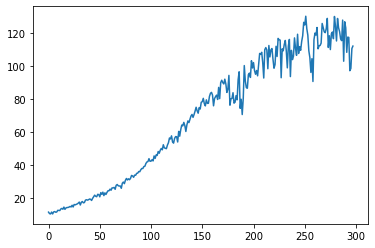

In [22]:
import matplotlib.pyplot as plt
t= res_eval + res_eval_3
plt.plot(t)

In [14]:
torch.save(agent.actor_critic, "ptmt_actor_critic")

# META-TESTING

In [35]:
from functools import reduce

import numpy as np
import torch

from sklearn.gaussian_process import GaussianProcessRegressor
from utilities.observation_utils import augment_obs_posterior, get_posterior_no_prev
from ppo_a2c.algo.ppo import PPO
from ppo_a2c.envs import make_vec_envs_multi_task
from ppo_a2c.model import MLPBase, Policy
from ppo_a2c.storage import RolloutStorage
import matplotlib.pyplot as plt

def temp_test_task_sequence(agent, gp_list, sw_size, env_name, seed, log_dir, envs_kwargs_list, init_prior, use_env_obs,
                            num_eval_processes, use_true_sigma=False):
    print("Meta-testing...")

    num_tasks = len(envs_kwargs_list)

    eval_episode_rewards = []
    prediction_mean = []

    prior = init_prior
    posterior_history = torch.empty(num_tasks, num_eval_processes, 2 * agent.latent_dim)

    for t, kwargs in enumerate(envs_kwargs_list):
        # Task creation
        temp = [kwargs for _ in range(num_eval_processes)]
        eval_envs = make_vec_envs_multi_task(env_name, seed, num_eval_processes, agent.gamma, log_dir, agent.device,
                                             False, temp, num_frame_stack=None)

        obs = eval_envs.reset()
        obs = augment_obs_posterior(obs, agent.latent_dim, prior,
                                    use_env_obs, rescale_obs=agent.rescale_obs,
                                    max_old=agent.max_old, min_old=agent.min_old,
                                   is_prior=True)

        eval_recurrent_hidden_states = torch.zeros(
            num_eval_processes, agent.actor_critic.recurrent_hidden_state_size, device=agent.device)
        eval_masks = torch.zeros(num_eval_processes, 1, device=agent.device)

        use_prev_state = False

        task_epi_rewards = []

        while len(task_epi_rewards) < num_eval_processes:
            with torch.no_grad():
                _, action, _, eval_recurrent_hidden_states = agent.actor_critic.act(
                    obs,
                    eval_recurrent_hidden_states,
                    eval_masks,
                    deterministic=False)

            # Observe reward and next obs
            obs, reward, done, infos = eval_envs.step(action)
            posterior = get_posterior_no_prev(agent.vae, action, reward, prior,
                                              min_action=agent.min_action, max_action=agent.max_action,
                                              use_prev_state=use_prev_state)
            obs = augment_obs_posterior(obs, agent.latent_dim, posterior,
                                        use_env_obs, rescale_obs=agent.rescale_obs,
                                        max_old=agent.max_old, min_old=agent.min_old,
                                       is_prior=False)

            use_prev_state = True
            eval_masks = torch.tensor(
                [[0.0] if done_ else [1.0] for done_ in done],
                dtype=torch.float32,
                device=agent.device)

            for info in infos:
                if 'episode' in info.keys():
                    total_epi_reward = info['episode']['r']
                    task_epi_rewards.append(total_epi_reward)

        eval_episode_rewards.append(np.mean(task_epi_rewards))
        eval_envs.close()

        # Retrieve new prior for the identified model so far
        posterior_history[t, :, :] = posterior
        x = np.atleast_2d(np.arange(t + 1)).T
        for dim in range(agent.latent_dim):
            for proc in range(num_eval_processes):
                if t > sw_size:
                    gp_list[dim][proc].fit(x[-sw_size:],
                                           np.atleast_2d(
                                               posterior_history[t + 1 - sw_size:t + 1, proc, dim].numpy()).T)
                else:
                    gp_list[dim][proc].fit(x,
                                           np.atleast_2d(posterior_history[0:t + 1, proc, dim].numpy()).T)

        prior = []
        curr_pred = []
        for proc in range(num_eval_processes):
            prior_proc = torch.empty(2, agent.latent_dim)
            for dim in range(agent.latent_dim):
                x_points = np.atleast_2d(np.array([t+1])).T
                y_pred, sigma = gp_list[dim][proc].predict(x_points, return_std=True)
                prior_proc[0, dim] = y_pred[0, 0]
                if use_true_sigma:
                    if proc == 0:
                        print(sigma[0])
                    prior_proc[1, dim] = sigma[0]
                else:
                    prior_proc[1, dim] = 10.
                curr_pred.append(y_pred[0][0])
            prior.append(prior_proc)
        prediction_mean.append(np.mean(curr_pred))
        # y = [envs_kwargs_list[j]['mean'] for j in range(t+1)]
        # plot_gp(gp_list[0][0], y, t+1)
    return eval_episode_rewards, posterior_history, prediction_mean


def plot_gp(gp, y, max_round_so_far):
    x = np.arange(max_round_so_far)
    x = np.atleast_2d(x).T
    y_pred, sigma = gp.predict(x, return_std=True)
    
    plt.figure()
    plt.plot(x, y, 'r.', markersize=10, label='Observations')
    plt.plot(x, y_pred, 'b-', label='Prediction')
    plt.fill(np.concatenate([x, x[::-1]]),
             np.concatenate([y_pred - 1.9600 * sigma,
                            (y_pred + 1.9600 * sigma)[::-1]]),
             alpha=.5, fc='b', ec='None', label='95% confidence interval')
    plt.ylim(-10, 50)
    plt.show()

def plot_results(res, test_kwargs, posterior_history, gp_pred):
    # Plot reward
    plt.plot(res)
    plt.show()

    # Retrieve env data
    a_list = [test_kwargs[i]['mean'] for i in range(len(test_kwargs))]
    std_list = [test_kwargs[i]['std'] for i in range(len(test_kwargs))]
    
    # Compare posterior with real tasks
    gp_pred.insert(0, gp_pred[0])
    plt.plot(gp_pred, label="GP pred")
    plt.plot(a_list, label="True task")
    plt.plot(posterior_history[:, :, 0].mean(1), label="Posterior")
    plt.legend()
    plt.show()

Meta-testing...


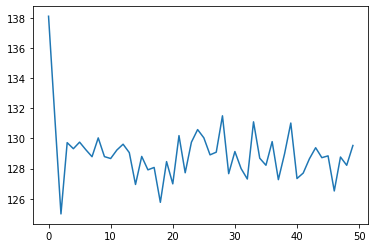

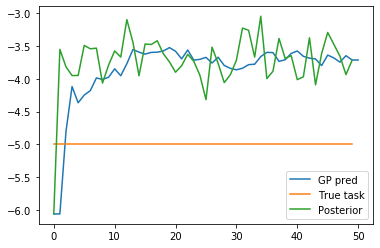

In [122]:
gp_list, test_kwargs, init_prior_test = get_const_task_sequence(0.25, 1, 10)
res, posterior_history, gp_pred = temp_test_task_sequence(agent, gp_list, 10, env_name, 0, ".", test_kwargs, init_prior_test, False, 10, False)
plot_results(res, test_kwargs, posterior_history, gp_pred)

In [26]:
gp_list, test_kwargs, init_prior_test = get_const_task_sequence(0.25, 1, 20)
res, posterior_history, gp_pred = temp_test_task_sequence(agent, gp_list, 10, env_name, 0, ".", test_kwargs, init_prior_test, False, 20, True)
plot_results(res, test_kwargs, posterior_history, gp_pred)

Meta-testing...


TypeError: make() argument after ** must be a mapping, not Tensor

Meta-testing...


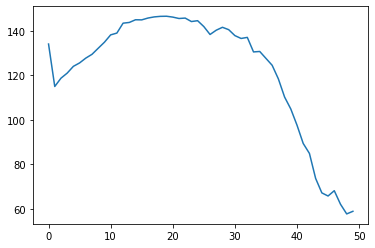

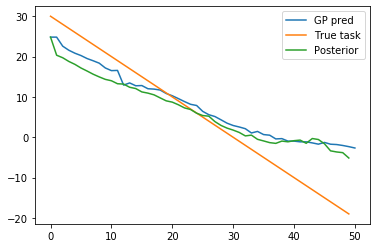

In [29]:
gp_list, test_kwargs, init_prior_test = get_linear_task_sequence(0.25, 1, 20)
res, posterior_history, gp_pred = temp_test_task_sequence(agent, gp_list, 10, env_name, 0, ".", test_kwargs, init_prior_test, False, 20, False)
plot_results(res, test_kwargs, posterior_history, gp_pred)

Meta-testing...


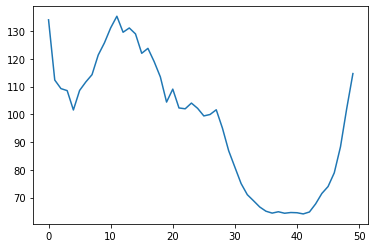

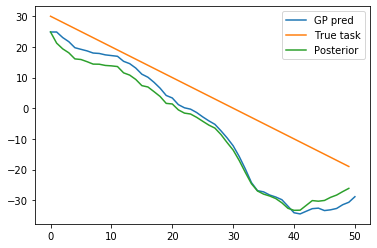

In [30]:
gp_list, test_kwargs, init_prior_test = get_linear_task_sequence(0.25, 1, 20)
res, posterior_history, gp_pred = temp_test_task_sequence(agent, gp_list, 10, env_name, 0, ".", test_kwargs, init_prior_test, False, 20, True)
plot_results(res, test_kwargs, posterior_history, gp_pred)

Meta-testing...


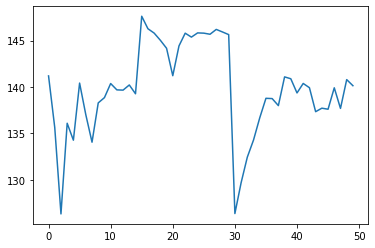

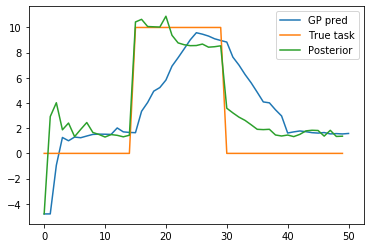

In [31]:
gp_list, test_kwargs, init_prior_test = get_phase_task_sequence(0.25, 1, 20)
res, posterior_history, gp_pred = temp_test_task_sequence(agent, gp_list, 10, env_name, 0, ".", test_kwargs, init_prior_test, False, 20, False)
plot_results(res, test_kwargs, posterior_history, gp_pred)

Meta-testing...
0.039076142346434285
0.027004046229745705
0.01940520234483366
0.0031622771377127004
0.016995488981371893
0.013646305202940667
0.003162277660168379
0.003162277660168379
0.0053716610093075875
0.011342443898336696
0.009573054800988667
0.013157664616277688
0.011452237926698878
0.0031622763781409113
0.013027351528827235
0.01123137717259567
0.013026984231094302
0.00316227669536001
0.01356149011397577
0.013562493764008933
0.013252331107166549
0.0031622760929533866
0.0031622776430062353
0.013560324711434741
0.013559624794981932
0.011146793908033466
0.011564319272585893
0.012486958867130573
0.0117005807986925
0.011290840636428455
0.0031622775306696955
0.011713209438096304
0.011179655247509192
0.008138148858802569
0.013077060590662673
0.013559831230178163
0.0031622760790376626
0.012505143742435205
0.003162277660168379
0.011251033139943883
0.013559341179173031
0.012861268532066868
0.012368985922625931
0.013560191854697218
0.013559740103657434
0.011684067630143187
0.011226440333478

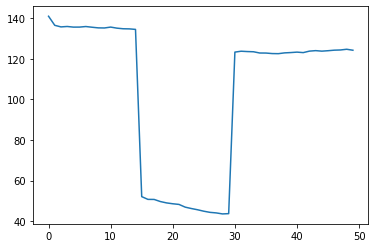

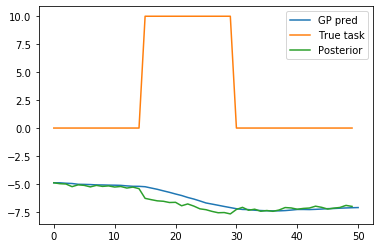

In [39]:
gp_list, test_kwargs, init_prior_test = get_phase_task_sequence(10, 1, 20)
res, posterior_history, gp_pred = temp_test_task_sequence(agent, gp_list, 10, env_name, 0, ".", test_kwargs, init_prior_test, False, 20, True)
plot_results(res, test_kwargs, posterior_history, gp_pred)

Meta-testing...


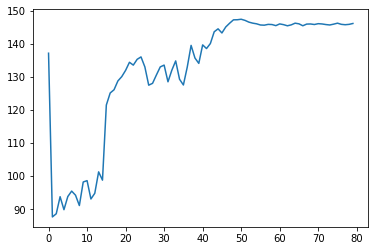

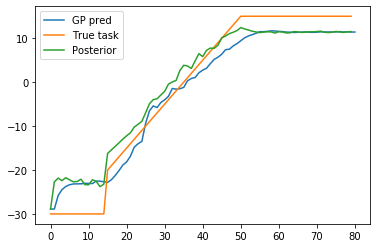

In [33]:
gp_list, test_kwargs, init_prior_test = get_abrupt_and_smooth(0.25, 1, 20)
res, posterior_history, gp_pred = temp_test_task_sequence(agent, gp_list, 10, env_name, 0, ".", test_kwargs, init_prior_test, False, 20, False)
plot_results(res, test_kwargs, posterior_history, gp_pred)